이전에 데이터 전처리와 데이터 분석한 내용을 바탕으로 전력소비량kWh)를 예측하는 AI 모델을 구현해보자.

train data에서 건물 번호가 가지는 1~100이 수치적 연관이 없고 건물 유형 역시 그러하기에 예측 모델을 구현하는 두가지 방법이 있다.

첫번째 방법은 label encoding을 사용하는 방법이며 1~100 까지의 건물 번호를 One-hot encoding을 통해 처리하는 방법이 있다.

이 방법은 100가지 건물번호를 One-hot encoding을 하게되면 columns의 수가 급증하여 모델의 학습속도가 줄어드는 단점이 있다.

두번째 방법은 각 건물번호별 Modeling을 진행하는 방법이며 이 방법은 건물번호별 Modeling을 진행하게 되면 각 Model별 학습 data의 숫자가 줄어들게 된다.

학습 데이터가 204,000 개로 적지 않기에 건물번호별 Modeling을 실시하고 건물유형은 제거하여 학습을 진행하고자 한다.

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

from tqdm.auto import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from pycaret.regression import *

## Load

In [2]:
train_df = pd.read_csv('./train_preprocessed.csv')
test_df = pd.read_csv('./test_preprocessed.csv')

## data preprocess

건물유형은 학습에 사용하지 않기에 제거한다.

In [3]:
train_df = train_df.drop(['건물유형'], axis=1)
train_df

,Unnamed: 0,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),day,time,weekday,holiday
0,0,1,18.6,0.0,0.9,42.0,1085.28,152,-8.660254e-01,1,0
1,1,1,18.0,0.0,1.1,45.0,1047.36,152,-9.659258e-01,1,0
2,2,1,17.7,0.0,1.5,45.0,974.88,152,-1.000000e+00,1,0
3,3,1,16.7,0.0,1.4,48.0,953.76,152,-9.659258e-01,1,0
4,4,1,18.4,0.0,2.8,43.0,986.40,152,-8.660254e-01,1,0
...,...,...,...,...,...,...,...,...,...,...,...
203995,203995,100,23.1,0.0,0.9,86.0,881.04,236,2.588190e-01,1,1
203996,203996,100,22.4,0.0,1.3,86.0,798.96,236,1.224647e-16,1,1
203997,203997,100,21.3,0.0,1.0,92.0,825.12,236,-2.588190e-01,1,1
203998,203998,100,21.0,0.0,0.3,94.0,640.08,236,-5.000000e-01,1,1


### Pycaret

AutoML 툴인 pycaret을 사용하여 학습에 적합한 모델을 찾는다.

In [4]:
base_setup = setup(session_id=0, data=train_df, target='전력소비량(kWh)')

,Description,Value
0,Session id,0
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 11)"
4,Transformed data shape,"(204000, 11)"
5,Transformed train set shape,"(142800, 11)"
6,Transformed test set shape,"(61200, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [5]:
models = compare_models(n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,152.8072,85134.2993,291.7482,0.9856,0.1360,0.0829,15.7970
et,Extra Trees Regressor,154.7568,90601.6634,300.9936,0.9847,0.1393,0.0841,8.0960
xgboost,Extreme Gradient Boosting,225.3155,122925.4273,350.5360,0.9792,0.1807,0.1290,2.0350
dt,Decision Tree Regressor,184.5909,153566.2558,391.7654,0.9741,0.1802,0.0984,0.2870
lightgbm,Light Gradient Boosting Machine,300.8599,184982.3466,430.0348,0.9688,0.2310,0.1845,0.2850
knn,K Neighbors Regressor,284.7899,264251.8172,513.9617,0.9554,0.2368,0.1576,0.2160
gbr,Gradient Boosting Regressor,613.7933,773165.0633,879.1689,0.8696,0.4055,0.3838,3.8010
ada,AdaBoost Regressor,1359.1927,2654909.8853,1624.9579,0.5507,0.8110,1.1691,1.7220
lar,Least Angle Regression,1366.6325,5382220.6917,2319.1908,0.0932,0.7231,0.8222,0.0790
lr,Linear Regression,1366.6325,5382220.6921,2319.1908,0.0932,0.7231,0.8222,0.5430


여러 지표에서 Random Forest Regressor이 좋은 성능을 보여주고 있다. 몇몇 건물번호별 모델링에서도 그런지 확인해보자.

In [7]:
setup1 = setup(session_id=0, data=train_df[train_df['건물번호']==1], target='전력소비량(kWh)')

,Description,Value
0,Session id,0
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(2040, 11)"
4,Transformed data shape,"(2040, 11)"
5,Transformed train set shape,"(1428, 11)"
6,Transformed test set shape,"(612, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [8]:
models1 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,191.9793,71909.3961,267.5105,0.9421,0.1059,0.0789,0.0830
lightgbm,Light Gradient Boosting Machine,208.6744,84007.1416,288.9163,0.9323,0.1129,0.0855,0.0920
gbr,Gradient Boosting Regressor,231.6840,91600.6636,302.0735,0.9262,0.1218,0.0967,0.0840
rf,Random Forest Regressor,228.5382,100413.5882,315.1765,0.9193,0.1224,0.0932,0.1680
et,Extra Trees Regressor,228.4104,105152.0638,321.9025,0.9155,0.1258,0.0935,0.1260
lr,Linear Regression,287.6986,131715.9222,362.3006,0.8941,0.1818,0.1285,0.5120
ridge,Ridge Regression,287.8798,131713.5721,362.2994,0.8941,0.1805,0.1284,0.0350
llar,Lasso Least Angle Regression,287.9731,131694.6925,362.2966,0.8941,0.1783,0.1283,0.0360
br,Bayesian Ridge,287.7767,131712.8470,362.2973,0.8941,0.1812,0.1285,0.0360
ada,AdaBoost Regressor,307.5693,141286.3080,375.0683,0.8862,0.1538,0.1302,0.0650


In [9]:
setup2 = setup(session_id=0, data=train_df[train_df['건물번호']==10], target='전력소비량(kWh)')
models2 = compare_models()

,Description,Value
0,Session id,0
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(2040, 11)"
4,Transformed data shape,"(2040, 11)"
5,Transformed train set shape,"(1428, 11)"
6,Transformed test set shape,"(612, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,209.9364,77187.0287,277.3422,0.7674,0.0711,0.0536,0.1510
xgboost,Extreme Gradient Boosting,210.6153,78830.6508,279.8737,0.7620,0.0718,0.0537,0.1050
rf,Random Forest Regressor,216.6503,80957.6036,284.1412,0.7559,0.0731,0.0555,0.1820
lightgbm,Light Gradient Boosting Machine,217.4045,81680.9305,285.1918,0.7531,0.0730,0.0553,0.1160
knn,K Neighbors Regressor,231.7636,90490.0664,300.0419,0.7277,0.0775,0.0597,0.0690
gbr,Gradient Boosting Regressor,244.4366,94574.7822,306.8638,0.7147,0.0783,0.0622,0.1110
ada,AdaBoost Regressor,297.7633,130101.0356,360.2080,0.6066,0.0921,0.0759,0.0910
dt,Decision Tree Regressor,267.3308,136298.1376,368.6455,0.5894,0.0949,0.0679,0.0640
ridge,Ridge Regression,381.0764,218273.7365,466.6551,0.3440,0.1195,0.0976,0.0660
llar,Lasso Least Angle Regression,380.9671,218321.7111,466.7147,0.3439,0.1196,0.0976,0.0680


In [10]:
setup3 = setup(session_id=0, data=train_df[train_df['건물번호']==50], target='전력소비량(kWh)')
models3 = compare_models()

,Description,Value
0,Session id,0
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(2040, 11)"
4,Transformed data shape,"(2040, 11)"
5,Transformed train set shape,"(1428, 11)"
6,Transformed test set shape,"(612, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,129.8274,34133.4102,184.0864,0.8883,0.0595,0.0424,0.1360
lightgbm,Light Gradient Boosting Machine,139.7220,39601.7918,198.0398,0.8704,0.0639,0.0457,0.1420
gbr,Gradient Boosting Regressor,161.8451,47350.8515,217.3017,0.8458,0.0703,0.0529,0.1360
rf,Random Forest Regressor,154.0565,48080.2533,218.5419,0.8427,0.0705,0.0503,0.2260
et,Extra Trees Regressor,160.2250,55240.0851,234.3642,0.8194,0.0758,0.0523,0.1790
lr,Linear Regression,196.1763,57010.0564,238.5728,0.8151,0.0815,0.0666,0.0940
ridge,Ridge Regression,196.2477,57013.0038,238.5794,0.8151,0.0813,0.0666,0.1020
br,Bayesian Ridge,196.2250,57011.7634,238.5768,0.8151,0.0813,0.0666,0.0920
llar,Lasso Least Angle Regression,196.4518,57073.8727,238.7095,0.8149,0.0810,0.0666,0.0970
knn,K Neighbors Regressor,175.6806,59947.8309,244.4144,0.8057,0.0823,0.0583,0.0950


In [11]:
setup4 = setup(session_id=0, data=train_df[train_df['건물번호']==100], target='전력소비량(kWh)')
models4 = compare_models()

,Description,Value
0,Session id,0
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(2040, 11)"
4,Transformed data shape,"(2040, 11)"
5,Transformed train set shape,"(1428, 11)"
6,Transformed test set shape,"(612, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,43.2811,3466.9384,58.6940,0.9643,0.0822,0.0586,0.1630
lightgbm,Light Gradient Boosting Machine,46.1530,3749.8590,61.0044,0.9614,0.0846,0.0621,0.1690
gbr,Gradient Boosting Regressor,48.5642,4098.3067,63.8370,0.9579,0.0885,0.0660,0.1790
rf,Random Forest Regressor,49.8406,4385.2749,66.0074,0.9549,0.0929,0.0676,0.2250
et,Extra Trees Regressor,50.3764,4515.5604,66.8792,0.9536,0.0952,0.0688,0.2060
ada,AdaBoost Regressor,68.2852,7093.8099,84.1417,0.9269,0.1279,0.1020,0.1470
dt,Decision Tree Regressor,65.8987,8253.8325,90.6149,0.9153,0.1276,0.0892,0.1230
ridge,Ridge Regression,83.2005,10442.3894,102.0916,0.8925,0.1458,0.1154,0.1220
br,Bayesian Ridge,83.1973,10442.1036,102.0905,0.8925,0.1458,0.1154,0.1220
lr,Linear Regression,83.1920,10441.8506,102.0897,0.8925,0.1458,0.1154,0.1190


data 수량이 적은 건물번호별 data에선 xgboost가 높은 성능을 보여주었기에 xgboost를 사용하여 전력소비량을 예측해 보자.


### GridSearch

GridSearchCV를 사용하여 model이 train data를 예측하는데 최적의 parameters를 찾아 model을 tuning할 것이다.

우선 전력소비량 예측 대회에 사용되는 평가지표인 SMAPE를 정의한다.

In [3]:
def SMAPE(true, preds):
    return 100 * np.mean((np.abs(true - preds)) / (np.abs(true) + np.abs(preds)))

SMAPE는 예측량이 실제량 보다 많은 경우의 loss의 크기가 예측량이 실제량 보다 적은 경우의 loss의 크기 보다 작기 때문에 실제 소비량보다 준비된 전력량이 적을 때 패널티가 큰 실제 경우와 유사하다고 볼 수 있다.

GridSearch 에 필요한 패키지들과 XGBOOST를 Import한다.

In [4]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

GridSearch 에 사용할 parameters를 정의한다.

In [5]:
grid_params = { 'n_estimators' : [100],
                'eta' : [0.1],
                'min_child_weight' : [1,3,5,7],
                'max_depth' : [3,5,7,9],
                'subsample' : [0.5, 0.8, 1],
                'colsample_bytree' : [0.8, 0.9, 1]
                }

GridSearchCV를 사용해 model별 최적의 parameters를 찾아 csv로 저장한다.

In [ ]:
#params_df = pd.DataFrame(columns=['n_estimators', 'eta', 'min_child_weight', 'max_depth', 'subsample', 'colsample_bytree'])
params_df = pd.read_csv('./hyperparameter.csv')
for i in tqdm(np.arange(1, 101)):
    y = train_df.loc[train_df['건물번호'] == i, '전력소비량(kWh)']
    x = train_df.loc[train_df['건물번호'] == i].drop(['전력소비량(kWh)', '건물번호'], axis=1)

    gcv = GridSearchCV(estimator=XGBRegressor(seed=0, gpu_id=0,
                                              tree_method='gpu_hist', predictor='gpu_predictor'),
                       param_grid=grid_params, scoring=make_scorer(SMAPE, greater_is_better=False), cv=3, refit=True,
                       verbose=False)

    gcv.fit(x, y)

    params = gcv.best_params_

    params_df = pd.concat([params_df, pd.DataFrame(params, index=[0])], axis=0)
    params_df.to_csv('./hyperparameter.csv', index=False)  # save the tuned parameters


GridSearch를 통해 얻은 parameters로 Model의 best iteration을 찾는다.

In [9]:
xgb_params = pd.read_csv('./hyperparameter.csv')
best_iteration = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    y = train_df.loc[train_df['건물번호'] == i+1, '전력소비량(kWh)']
    x = train_df.loc[train_df['건물번호'] == i+1].drop(['건물번호', '전력소비량(kWh)'], axis=1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y=y, X=x, test_size=168)

    xgb = XGBRegressor(n_estimators=10000, eta=0.01, min_child_weight=xgb_params.iloc[i, 2],
                           max_depth=xgb_params.iloc[i, 3], subsample=xgb_params.iloc[i, 4], colsample_bytree=xgb_params.iloc[i, 5],
                            seed=0, gpu_id=0, tree_method='gpu_hist', predictor='gpu_predictor')

    xgb.fit(x_train, y_train, eval_set=[(x_train, y_train),
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    best_iteration.append(xgb.best_iteration + 1)

xgb_params['best_iteration'] = best_iteration
xgb_params.to_csv('./hyperparameter_2.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

## Test

xgb_params를 이용해 학습을 진행한다. random한 요소를 줄이기 위해 seed값을 0~5일 때 예측값을 평균을 내어 사용한다. 학습한 모델로 test_df의 결과값을 예측한다.

In [10]:
xgb_params = pd.read_csv('./hyperparameter_2.csv')
best_iteration = xgb_params['best_iteration'].to_list()

preds = np.array([])
for i in tqdm(range(100)):
    pred_df = pd.DataFrame()

    for seed in [0, 1, 2, 3, 4, 5]:
        y = train_df.loc[train_df['건물번호'] == i+1, '전력소비량(kWh)']
        x = train_df.loc[train_df['건물번호'] == i+1].drop(columns=['건물번호', '전력소비량(kWh)'])

        test_x = test_df.loc[test_df['건물번호'] == i+1].drop(columns=['건물번호'])
        model = XGBRegressor(seed=seed, n_estimators=best_iteration[i], eta=0.1, min_child_weight=xgb_params.iloc[i, 2],
                           max_depth=xgb_params.iloc[i, 3], subsample=xgb_params.iloc[i, 4], colsample_bytree=xgb_params.iloc[i, 5])
        model.fit(x, y)
        y_pred = model.predict(test_x)
        pred_df.loc[:, seed] = y_pred 

    pred = pred_df.mean(axis=1)
    preds = np.append(preds, pred)

preds = pd.Series(preds)
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = preds
submission.to_csv('./final.csv', index = False)

  0%|          | 0/100 [00:00<?, ?it/s]

리더보드에 올려 결과를 확인한다.

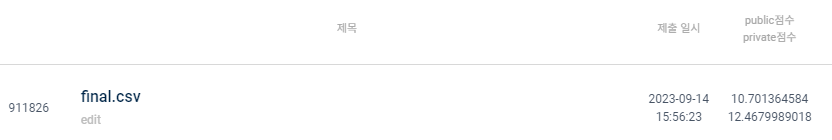